<a href="https://colab.research.google.com/github/AHApiko/Kaggle-FloodProbability/blob/main/Flood_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745305 entries, 0 to 745304
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   id                               745305 non-null  int64
 1   MonsoonIntensity                 745305 non-null  int64
 2   TopographyDrainage               745305 non-null  int64
 3   RiverManagement                  745305 non-null  int64
 4   Deforestation                    745305 non-null  int64
 5   Urbanization                     745305 non-null  int64
 6   ClimateChange                    745305 non-null  int64
 7   DamsQuality                      745305 non-null  int64
 8   Siltation                        745305 non-null  int64
 9   AgriculturalPractices            745305 non-null  int64
 10  Encroachments                    745305 non-null  int64
 11  IneffectiveDisasterPreparedness  745305 non-null  int64
 12  DrainageSystems               

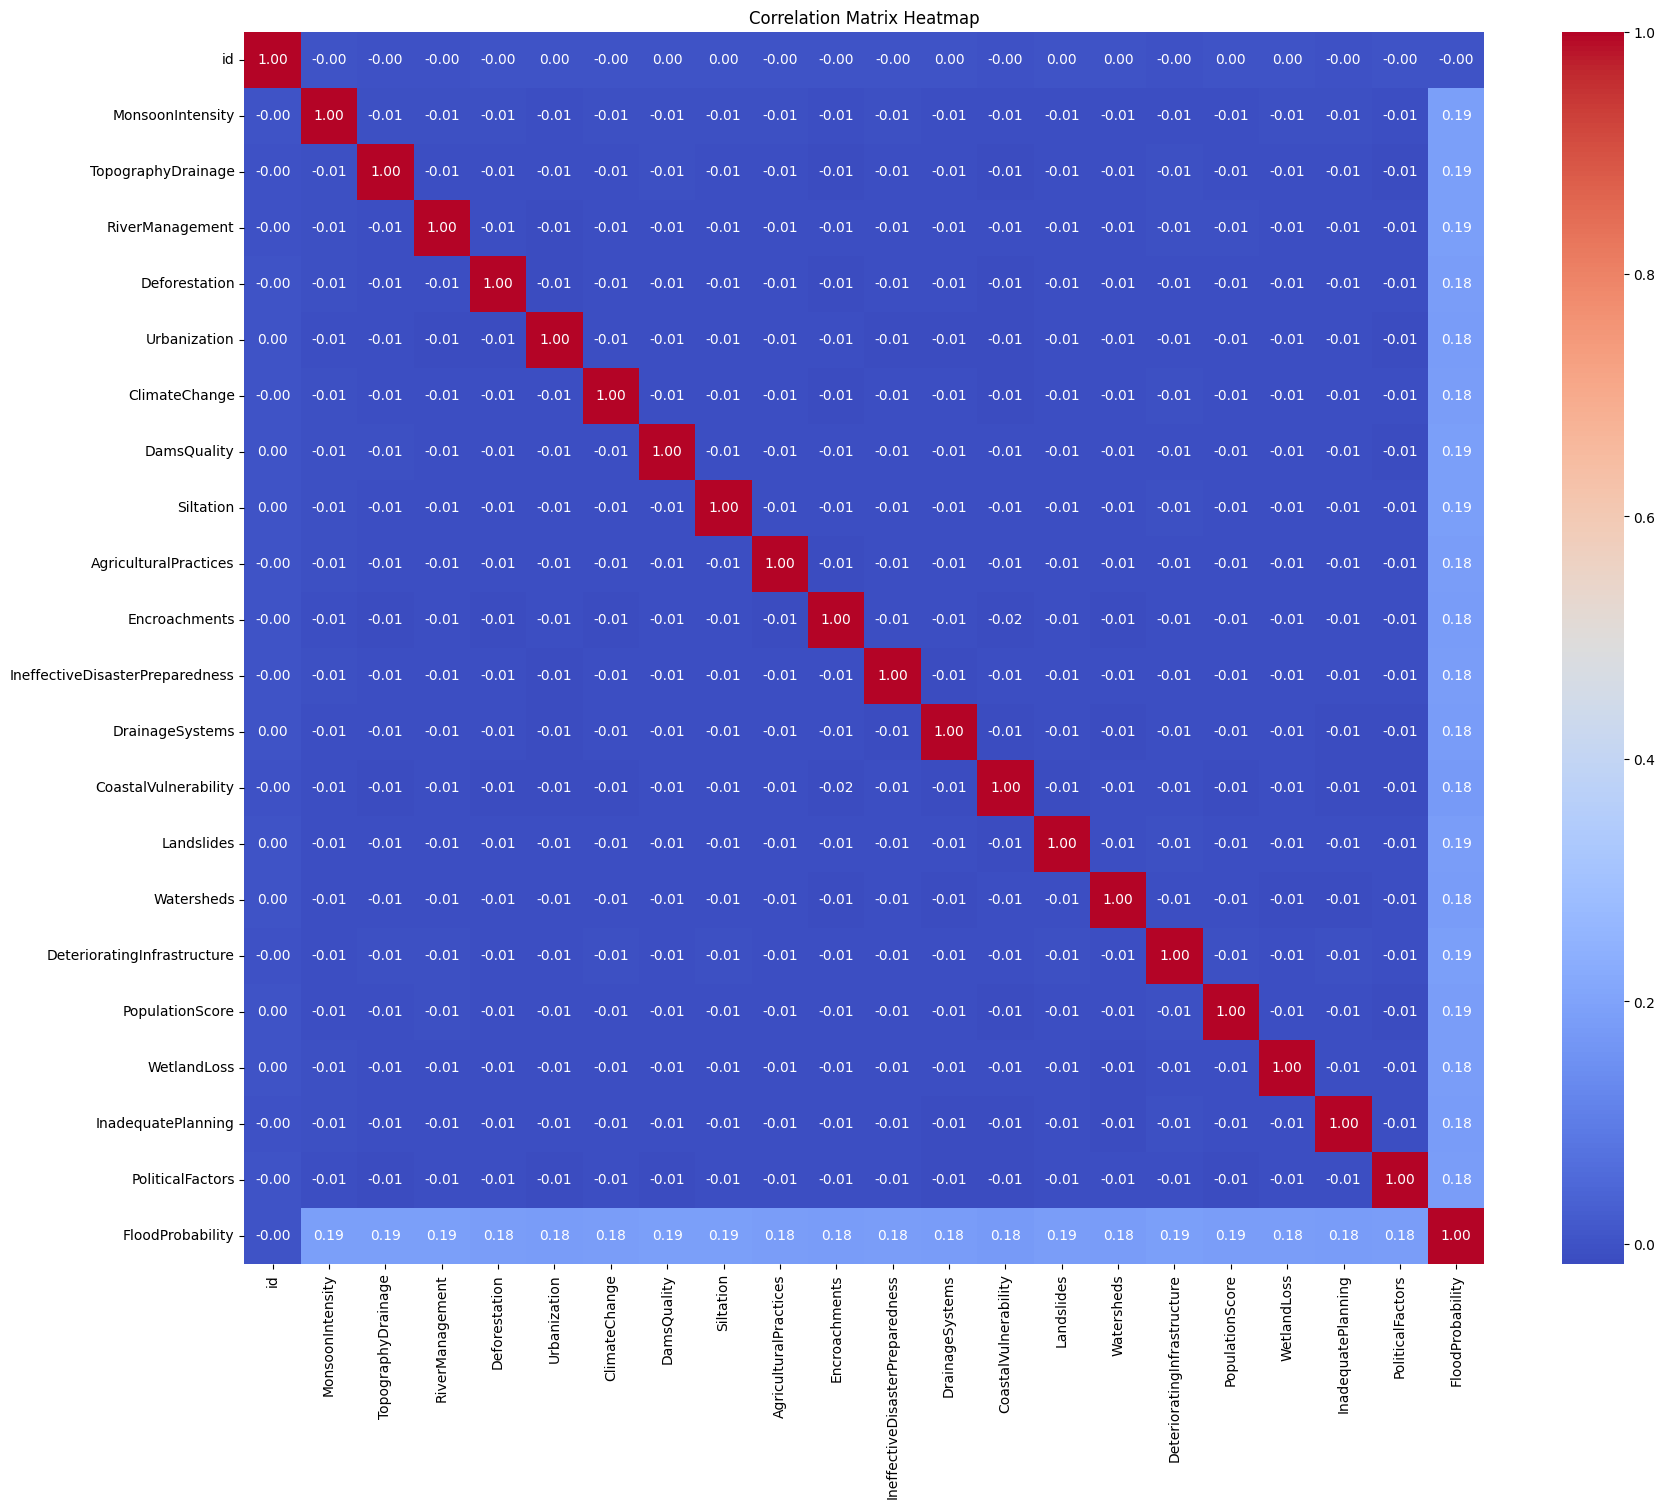

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Dropout

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

test.info()
train.info()

correlation_matrix = train.corr()

# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
# Assuming 'train' is your DataFrame containing the data
# Assuming 'train' is your DataFrame containing the data
initial_features = ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation',
                    'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices',
                    'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability',
                    'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore',
                    'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors']
# Feature engineering
train['fsum'] = train[initial_features].sum(axis=1)
train['special1'] = train['fsum'].isin(np.arange(72, 76)).astype(int)

# Define features and target variable
X = train[initial_features + ['special1']]
y = train['FloodProbability']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define the neural network architecture with Swish activation function
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Choose an optimizer (you can also use advanced optimizers like AdamW or RMSprop)
optimizer = optimizers.Adam(learning_rate=0.0001)  # Adam optimizer with default parameters


# Compile the model with the custom loss function and the chosen optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_data=(X_val_scaled, y_val), callbacks=early_stopping)

# Make predictions
predictions = model.predict(X_val_scaled)

# Compute R2 score
r2 = r2_score(y_val, predictions)
print('R2 score:', r2)

Epoch 1/30
27949/27949 [==============================] - 93s 3ms/step - loss: 4.3327e-04 - mae: 0.0162 - val_loss: 3.8558e-04 - val_mae: 0.0156
Epoch 2/30
27949/27949 [==============================] - 93s 3ms/step - loss: 3.7617e-04 - mae: 0.0153 - val_loss: 3.6781e-04 - val_mae: 0.0151
Epoch 3/30
27949/27949 [==============================] - 87s 3ms/step - loss: 3.6523e-04 - mae: 0.0150 - val_loss: 3.6266e-04 - val_mae: 0.0150
Epoch 4/30
27949/27949 [==============================] - 89s 3ms/step - loss: 3.6147e-04 - mae: 0.0149 - val_loss: 3.5960e-04 - val_mae: 0.0149
Epoch 5/30
27949/27949 [==============================] - 85s 3ms/step - loss: 3.5907e-04 - mae: 0.0148 - val_loss: 3.5879e-04 - val_mae: 0.0148
Epoch 6/30
27949/27949 [==============================] - 85s 3ms/step - loss: 3.5756e-04 - mae: 0.0148 - val_loss: 3.5763e-04 - val_mae: 0.0149
Epoch 7/30
27949/27949 [==============================] - 95s 3ms/step - loss: 3.5674e-04 - mae: 0.0148 - val_loss: 3.5688e-04 - v

In [ ]:
import itertools
from scipy.stats import pearsonr
import pandas as pd

def combine_features(df, features):
    """
    Combines the features by multiplying them element-wise.
    """
    combined_feature = df[features[0]]
    for feature in features[1:]:
        combined_feature *= df[feature]
    return combined_feature

def feature_combinations_correlation(df, target_column='FloodProbability'):
    """
    Calculates the correlation of all possible combinations of 3 features with the target column.
    """
    features = df.columns.tolist()
    features.remove(target_column)

    # Get all combinations of 4 features
    combinations = list(itertools.combinations(features, 3))

    # Store correlations
    correlations = []

    for combo in combinations:
        combined_feature = combine_features(df, combo)

        # Check if the combined feature is constant
        if combined_feature.nunique() == 1:
            continue

        corr, _ = pearsonr(combined_feature, df[target_column])
        correlations.append((combo, corr))

    # Sort correlations by the absolute value of the correlation in descending order
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)

    return correlations

df = pd.read_csv("train.csv")
correlations = feature_combinations_correlation(df)

for combo, corr in correlations[:10]:
    print(f'Combination: {combo}, Correlation: {corr}')

Combination: ('MonsoonIntensity', 'TopographyDrainage', 'RiverManagement'), Correlation: 0.30653549180841727
Combination: ('ClimateChange', 'DamsQuality', 'Siltation'), Correlation: 0.3043656596384547
Combination: ('DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss'), Correlation: 0.3042713314733091
Combination: ('TopographyDrainage', 'RiverManagement', 'Deforestation'), Correlation: 0.3037637960897055
Combination: ('DamsQuality', 'Siltation', 'AgriculturalPractices'), Correlation: 0.3037208290026201
Combination: ('Watersheds', 'DeterioratingInfrastructure', 'PopulationScore'), Correlation: 0.30315558180707103
Combination: ('Landslides', 'Watersheds', 'DeterioratingInfrastructure'), Correlation: 0.302955598558343
Combination: ('Urbanization', 'ClimateChange', 'DamsQuality'), Correlation: 0.3021078781858092
Combination: ('Urbanization', 'ClimateChange', 'Siltation'), Correlation: 0.30167436898221794
Combination: ('Watersheds', 'DeterioratingInfrastructure', 'WetlandLoss'), C

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Initial features
initial_features = ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation',
                    'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices',
                    'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability',
                    'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore',
                    'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors']

# Create new features
train['fsum'] = train[initial_features].sum(axis=1)
train['special1'] = train['fsum'].isin(np.arange(72, 76)).astype(int)
train['CombinedFeature1'] = train['MonsoonIntensity'] + train['TopographyDrainage'] + train['RiverManagement']
train['CombinedFeature2'] = train['ClimateChange'] + train['DamsQuality'] + train['Siltation']
train['CombinedFeature3'] = train['DeterioratingInfrastructure'] + train['PopulationScore'] + train['WetlandLoss']
train['CombinedFeature4'] = train['TopographyDrainage'] + train['RiverManagement'] + train['Deforestation']
train['CombinedFeature5'] = train['DamsQuality'] + train['Siltation'] + train['AgriculturalPractices']
train['CombinedFeature6'] = train['Watersheds'] + train['DeterioratingInfrastructure'] + train['PopulationScore']
train['CombinedFeature7'] = train['Landslides'] + train['Watersheds'] + train['DeterioratingInfrastructure']
train['CombinedFeature8'] = train['Urbanization'] + train['ClimateChange'] + train['DamsQuality']
train['CombinedFeature9'] = train['Urbanization'] + train['ClimateChange'] + train['Siltation']
train['CombinedFeature10'] = train['Watersheds'] + train['DeterioratingInfrastructure'] + train['WetlandLoss']

# Select top features
top_features = ['fsum', 'Encroachments', 'PoliticalFactors', 'CoastalVulnerability',
                'DrainageSystems', 'IneffectiveDisasterPreparedness', 'CombinedFeature2',
                'CombinedFeature6', 'CombinedFeature5', 'InadequatePlanning']

X = train[top_features]
y = train['FloodProbability']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define the objective function for Bayesian optimization
def objective(params):
    model = CatBoostRegressor(
        iterations=int(params['iterations']),
        learning_rate=params['learning_rate'],
        depth=int(params['depth']),
        l2_leaf_reg=params['l2_leaf_reg'],
        bagging_temperature=params['bagging_temperature'],
        random_strength=params['random_strength'],
        one_hot_max_size=int(params['one_hot_max_size']),
        verbose=0
    )
    model.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val), early_stopping_rounds=50, use_best_model=True)
    y_val_pred = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_val_pred)
    return {'loss': mse, 'status': STATUS_OK}

# Define the hyperparameter space
param_space = {
    'iterations': hp.quniform('iterations', 100, 1000, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'depth': hp.quniform('depth', 4, 10, 1),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 9, 1),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 3),
    'random_strength': hp.uniform('random_strength', 0, 1),
    'one_hot_max_size': hp.quniform('one_hot_max_size', 2, 20, 1)
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best parameters
print(f'Best Parameters: {best}')

# Train the final model with the best hyperparameters
best_model = CatBoostRegressor(
    iterations=int(best['iterations']),
    learning_rate=best['learning_rate'],
    depth=int(best['depth']),
    l2_leaf_reg=best['l2_leaf_reg'],
    bagging_temperature=best['bagging_temperature'],
    random_strength=best['random_strength'],
    one_hot_max_size=int(best['one_hot_max_size']),
    verbose=0
)
best_model.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val), early_stopping_rounds=50, use_best_model=True)

# Validate the final model
y_val_pred = best_model.predict(X_val_scaled)
print("Validation R^2:", r2_score(y_val, y_val_pred))
print("Validation MSE:", mean_squared_error(y_val, y_val_pred))

100%|██████████| 50/50 [1:00:25<00:00, 72.51s/trial, best loss: 0.00034720299983596355] 
Best Parameters: {'bagging_temperature': 2.8703677284922713, 'depth': 7.0, 'iterations': 853.0, 'l2_leaf_reg': 3.0, 'learning_rate': 0.11046108959486789, 'one_hot_max_size': 4.0, 'random_strength': 0.6379501497995129}
Validation R^2: 0.8664231788142075
Validation MSE: 0.00034720299983596355


In [ ]:
# Prepare test data
test['fsum'] = test[initial_features].sum(axis=1)
test['special1'] = test['fsum'].isin(np.arange(72, 76)).astype(int)
test['CombinedFeature1'] = test['MonsoonIntensity'] + test['TopographyDrainage'] + test['RiverManagement']
test['CombinedFeature2'] = test['ClimateChange'] + test['DamsQuality'] + test['Siltation']
test['CombinedFeature3'] = test['DeterioratingInfrastructure'] + test['PopulationScore'] + test['WetlandLoss']
test['CombinedFeature4'] = test['TopographyDrainage'] + test['RiverManagement'] + test['Deforestation']
test['CombinedFeature5'] = test['DamsQuality'] + test['Siltation'] + test['AgriculturalPractices']
test['CombinedFeature6'] = test['Watersheds'] + test['DeterioratingInfrastructure'] + test['PopulationScore']
test['CombinedFeature7'] = test['Landslides'] + test['Watersheds'] + test['DeterioratingInfrastructure']
test['CombinedFeature8'] = test['Urbanization'] + test['ClimateChange'] + test['DamsQuality']
test['CombinedFeature9'] = test['Urbanization'] + test['ClimateChange'] + test['Siltation']
test['CombinedFeature10'] = test['Watersheds'] + test['DeterioratingInfrastructure'] + test['WetlandLoss']
X_test = test[top_features]
X_test_scaled = scaler.transform(X_test)

# Make predictions on the test set
test_predictions = best_model.predict(X_test_scaled)

# Save predictions
submission = pd.DataFrame({
    'id': test['id'],  # Adjust the column name if it's different
    'FloodProbability': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")